In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.impute import KNNImputer
pd.set_option("display.max_columns", None)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
import pickle
import xgboost as xgb

In [38]:
df_Org = pd.read_csv('final_project.csv')

In [39]:
# Drop NA Rows
print("NA's In Dataset:",df_Org.isnull().sum().sum())

df_Org = df_Org.dropna()
print("After NA's Dropped:",(df_Org.isnull().sum().sum()))
print("Final Shape of Datframe:", df_Org.shape)

NA's In Dataset: 1608
After NA's Dropped: 0
Final Shape of Datframe: (158392, 51)


In [40]:
df_Final = df_Org.drop(['x37', 'x32', 'x24', 'x29', 'x30'], axis=1)

In [41]:
# Setup Dataset
X = df_Final
X = X.drop(['y'], axis=1)
y = df_Final['y']
y = y.astype('int')
print(X.shape)
len(y)

(158392, 45)


158392

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=76)
print('X', X.shape)
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('y_train', y_train.shape)
print('y_test', y_test.shape)
print("Test%", (X_test.shape[0]/X.shape[0]))
print("Train%", (X_train.shape[0]/X.shape[0]))

X (158392, 45)
X_train (110874, 45)
X_test (47518, 45)
y_train (110874,)
y_test (47518,)
Test% 0.3000025253800697
Train% 0.6999974746199303


In [44]:
rf = RandomForestClassifier(n_jobs=-1)

tuned_parameters = {'n_estimators': [10,50, 100, 300, 500], 
                    'criterion': ['gini', 'entropy'],
                    'max_depth':[5,10,15],
                    'min_samples_split':[2,4,9] 
                   }
scores = ['precision', 'recall']

In [45]:
%%time
for score in scores:
    print("# Tuning hyper-parameters for ********* %s" % score)
    print()

    clf = RandomizedSearchCV(RandomForestClassifier(), tuned_parameters, cv=5, n_iter=30, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
#     y_true, y_pred = y_test, clf.predict(X_test) # NEed to Add Back 
#     print(classification_report(y_true, y_pred)) # NEed to Add Back
    print()

# Tuning hyper-parameters for ********* precision

Best parameters set found on development set:

{'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'entropy'}

Grid scores on development set:

0.777 (+/-0.009) for {'n_estimators': 100, 'min_samples_split': 9, 'max_depth': 5, 'criterion': 'entropy'}
0.901 (+/-0.006) for {'n_estimators': 100, 'min_samples_split': 2, 'max_depth': 15, 'criterion': 'gini'}
0.903 (+/-0.006) for {'n_estimators': 300, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'entropy'}
0.776 (+/-0.005) for {'n_estimators': 300, 'min_samples_split': 9, 'max_depth': 5, 'criterion': 'gini'}
0.883 (+/-0.009) for {'n_estimators': 10, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'entropy'}
0.899 (+/-0.006) for {'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 15, 'criterion': 'entropy'}
0.776 (+/-0.011) for {'n_estimators': 50, 'min_samples_split': 4, 'max_depth': 5, 'criterion': 'gini'}
0.777 (+/-0.007) for {'n_estimators': 50

In [46]:
best_params = clf.best_params_
print(best_params)

{'n_estimators': 500, 'min_samples_split': 2, 'max_depth': 15, 'criterion': 'entropy'}


In [47]:
best_forest = RandomForestClassifier(**best_params)

Fitting our model to the train set
Creating predicted variables to compare against y_test
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     28497
           1       0.92      0.83      0.87     19021

    accuracy                           0.90     47518
   macro avg       0.91      0.89      0.90     47518
weighted avg       0.90      0.90      0.90     47518

CPU times: user 5min 44s, sys: 740 ms, total: 5min 45s
Wall time: 5min 45s


[Text(0, 0.5, 'No'), Text(0, 1.5, 'Yes')]

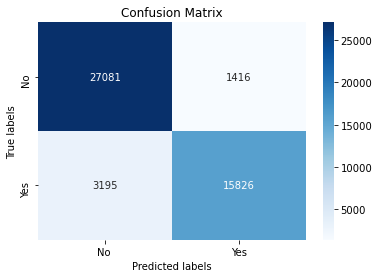

In [48]:
%%time
from sklearn.metrics import confusion_matrix
import seaborn as sns 

print("Fitting our model to the train set")
fit_forest = best_forest.fit(X_train, y_train)
print("Creating predicted variables to compare against y_test")

y_pred = fit_forest.predict(X_test)
# making classification report and confusion matrix
print(classification_report(y_test, y_pred))

ax= plt.subplot()

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, cmap="Blues", annot=True, fmt='d', ) # for decimal

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No ', 'Yes']); ax.yaxis.set_ticklabels(['No', 'Yes']);